# ohsome-api workshop notebook

### Imports
importing necessary libraries,
* matplotlib for drawing graphs
* pandas for working with table structured data
* numpy for basic array handling
* json for handling with json responses
* requests for http get/post requests
* csv for writing and loading csv files
* joblib for caching results of function

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import requests
import csv

# Use joblib for caching output
from sklearn.externals.joblib import Memory
memory = Memory(location='./tmp', verbose=0)

### Define global constasts

In [2]:
OHSOME_API = "https://api.ohsome.org/v0.9-dev"

# http://norbertrenner.de/osm/bbox.html
BBOX = { 
    "hd" : "8.6581,49.3836,8.7225,49.4363",
    "ma" : "8.4514,49.4589,8.5158,49.5114",
    "lu" :" 8.3936,49.4448,8.4579,49.4974"}

# https://en.wikipedia.org/wiki/ISO_8601
TIME_MONTHLY = "2007-11-01/2018-11-01/P1D"
METADATA = metadata = requests.get(OHSOME_API+"/metadata").json()

In [3]:
display(METADATA)

{'attribution': {'url': 'https://ohsome.org/copyrights',
  'text': '© OpenStreetMap contributors'},
 'apiVersion': '0.9',
 'extractRegion': {'spatialExtent': {'type': 'Polygon',
   'coordinates': [[[-180.0, -90.0],
     [180.0, -90.0],
     [180.0, 90.0],
     [-180.0, 90.0],
     [-180.0, -90.0]]]},
  'temporalExtent': {'fromTimestamp': '2007-01-01',
   'toTimestamp': '2019-02-19T23:00:00'}}}

### Declaring some helper functions

In [4]:
@memory.cache
def elements(agg,**params):
    res = requests.get(OHSOME_API+"/elements"+agg,params)
    return res

@memory.cache
def data(agg,**params):
    res = requests.get(OHSOME_API+"/elements"+agg, params)
    return res

@memory.cache
def dataFullHistory(agg,**params):
    res = requests.get(OHSOME_API+"/elementsFullHistory"+agg,params)
    return res

## Aggregation Endpoint
### count over time
json respons look like this:
```javascript
{ 
  'result': [
     {'timestamp': '2007-11-01T00:00:00Z', 'value': 181.0},
     {'timestamp': '2007-11-02T00:00:00Z', 'value': 181.0},
     {'timestamp': '2007-11-03T00:00:00Z', 'value': 181.0},
     // ...
   ]
}
```

'https://api.ohsome.org/v0.9-dev/elements/count?keys=highway&bboxes=8.6581%2C49.3836%2C8.7225%2C49.4363&time=2007-11-01%2F2018-11-01%2FP1D&types=way'

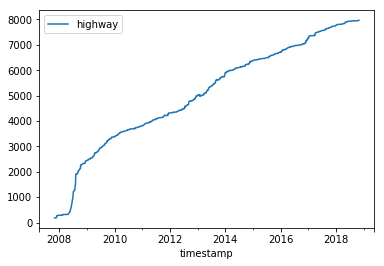

In [5]:
def count():
    keys="highway"
    res = elements("/count"
         ,keys=keys,values=None
         ,bboxes=BBOX['hd'],time=TIME_MONTHLY
         ,types="way")
    display(res.url)
    body = res.json()
    df = pd.DataFrame(body['result'])
    df.timestamp = pd.to_datetime(df.timestamp)
    df.rename(columns={'value':keys },inplace=True)
    df.set_index('timestamp', inplace=True)
    df.plot()
count()

### ratio between to groups over time
json response looks like this:
```javascript
{
  'ratioResult': [
    {'timestamp': '2007-11-01T00:00:00Z', 'value': 181.0, 'value2': 0.0, 'ratio': 0.0},
    {'timestamp': '2007-11-02T00:00:00Z', 'value': 181.0, 'value2': 0.0, 'ratio': 0.0},
    {'timestamp': '2007-11-03T00:00:00Z', 'value': 181.0, 'value2': 0.0, 'ratio': 0.0},
    // ...
   ]
}
```

'https://api.ohsome.org/v0.9-dev/elements/count/ratio?keys=highway&keys2=highway%2Cmaxspeed&bboxes=8.6581%2C49.3836%2C8.7225%2C49.4363&time=2007-11-01%2F2018-11-01%2FP1D&types=way&types2=way'

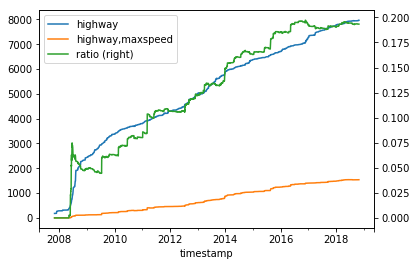

In [6]:
def ratio():
    keys = "highway"
    keys2 = "highway,maxspeed"
    res = elements("/count/ratio"
            ,keys=keys,values=None
            ,keys2=keys2, values2=None
            ,bboxes=BBOX['hd'],time=TIME_MONTHLY
            ,types="way", types2="way")
    display(res.url)
    body = res.json()
    df = pd.DataFrame(body['ratioResult'])
    df.timestamp = pd.to_datetime(df.timestamp)
    df.set_index('timestamp', inplace=True)
    df.rename(columns={'value':keys,'value2':keys2}, inplace=True)
    df[keys].plot(legend=True)
    df[keys2].plot(legend=True)
    df.ratio.plot(secondary_y=True,legend=True)
ratio()

### count over time group by boundingbox
json response looks like this:
```javascript
{
  'groupByResult': [
      {
          'result': [
              {'timestamp': '2007-11-01T00:00:00Z','value': 181.0},
              {'timestamp': '2010-07-26T00:00:00Z', 'value': 3685.0},
              {'timestamp': '2010-07-27T00:00:00Z', 'value': 3685.0},
              // ...
          ],
           'groupByObject': 'hd'
      },
      {
          'result': [
              {'timestamp': '2007-11-01T00:00:00Z', 'value': 411.0},
              // ...
          ],
          'groupByObject': 'ma'
      }, 
      // ...
   ]
}
```

'https://api.ohsome.org/v0.9-dev/elements/count/groupBy/boundary?keys=highway&bboxes=hd%3A8.6581%2C49.3836%2C8.7225%2C49.4363%7Cma%3A8.4514%2C49.4589%2C8.5158%2C49.5114%7Clu%3A+8.3936%2C49.4448%2C8.4579%2C49.4974&time=2007-11-01%2F2018-11-01%2FP1D&types=way'

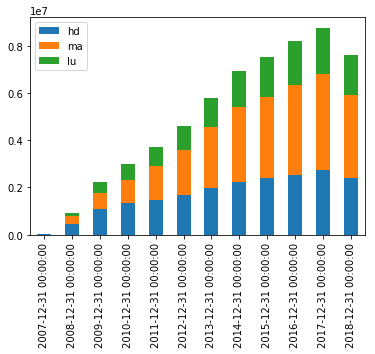

In [7]:
def groupBy():
    keys="highway"
    bboxes = '|'.join("{}:{}".format(k,v) for (k,v) in BBOX.items())
    res = elements("/count/groupBy/boundary"
            ,keys=keys,values=None
            ,bboxes=bboxes,time=TIME_MONTHLY
            ,types="way")
    display(res.url)
    body = res.json();
    df = pd.DataFrame()
    for groupBy in body['groupByResult']:
        series = pd.Series({row['timestamp']:row['value'] for row in groupBy['result']})
        df[groupBy['groupByObject']] = series
    df.set_index(pd.to_datetime(df.index),inplace=True)    
    df.resample('y').agg({'hd':'sum', 'ma':'sum','lu':'sum'}).plot.bar(stacked=True)
groupBy()

## data extraction endpoint
### snapshot data over time
json response looks like:
```javascript
{
 'type': 'FeatureCollection',
 'features': [
     {
         'type': 'Feature',
         'geometry': {
             'type': 'Point',
              'coordinates': [8.670155212077008, 49.399659869507616]},
         'properties': {
             '@osmId': 'way/135548604',
             '@snapshotTimestamp': '2019-02-19T23:00:00',
              // filter conditions are always present in the result
             'highway': 'living_street',
             
             // >>> only with properties contains 'metadata'
             '@changesetId': 39952663,
             '@lastEdit': '2016-06-11T13:27:58',
             '@osmType': 'WAY',
             '@version': 7,
             // <<<
            
             // >>> only with properties contains 'tags'
             'lit': 'yes',
             'name': 'Montpellierstraße',
             'smoothness': 'excellent',
             'surface': 'asphalt'
             // <<<
         }},
      {
          'type': 'Feature',
          'geometry': {
               'type': 'Point',
               'coordinates': [8.66844507130631, 49.400558346827175]},
          'properties': {
              '@osmId': 'way/135548612',
              '@snapshotTimestamp': '2019-02-19T23:00:00',
              'highway': 'living_street',
              '@changesetId': 39952663,
              '@osmType': 'WAY',
              '@lastEdit': '2016-06-11T13:27:55',
              '@version': 8,
              'lit': 'yes',
              //....
       },
       //....
  ]
}
```

In [8]:
def dataExtraction():
    keys="highway"
    
    res = data("/centroid"
            ,keys=keys,values=None
            ,bboxes=BBOX['hd'],time=None
            ,properties="tags,metadata"
            ,types="way,node,relation")
    display(res.url)   
    body = res.json()
    with open('./dataExtraction.csv',mode='w') as csv_file:
        csv_file = csv.writer(csv_file,delimiter=',',quotechar='"',quoting=csv.QUOTE_NONNUMERIC)
        csv_file.writerow(['timestamp','osmid','version','type','tagkey','tagvalue'])
        
        for f in body['features']:
            tags = f['properties']
            osmid = tags['@osmId']
            timestamp = tags['@lastEdit']
            version = tags['@version']
            type = tags['@osmType']
            for k,v in tags.items():
                if not k.startswith('@'):
                    csv_file.writerow([timestamp,osmid,version,type,k,v])
    
    return pd.read_csv("./dataExtraction.csv",dtype={'version':'int32'}, parse_dates=['timestamp'])
de = dataExtraction()

'https://api.ohsome.org/v0.9-dev/elements/centroid?keys=highway&bboxes=8.6581%2C49.3836%2C8.7225%2C49.4363&properties=tags%2Cmetadata&types=way%2Cnode%2Crelation'

In [9]:
de.head()

,timestamp,osmid,version,type,tagkey,tagvalue
0,2016-06-11 13:27:58,way/135548604,7,WAY,highway,living_street
1,2016-06-11 13:27:58,way/135548604,7,WAY,lit,yes
2,2016-06-11 13:27:58,way/135548604,7,WAY,name,Montpellierstraße
3,2016-06-11 13:27:58,way/135548604,7,WAY,smoothness,excellent
4,2016-06-11 13:27:58,way/135548604,7,WAY,surface,asphalt


### latest timestamp

In [10]:
def latestTimetamp():
    display(de.timestamp.max())
latestTimetamp()

Timestamp('2019-02-14 05:20:54')

### mean number of versions

In [11]:
def meanVersions():
    dfgb = de.groupby(['osmid','version']).size().reset_index(name="tmp")
    display(dfgb.version.mean())
meanVersions()

3.621616856210879

### ratio between diffrent osm types

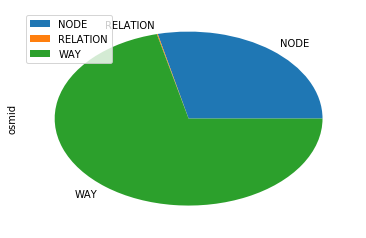

In [12]:
def ratioTypes():
    dfgb = de.groupby(['osmid','type']).size().reset_index(name='tmp')
    dfgb = dfgb.groupby(['type']).agg({'osmid':'count'})
    dfgb.plot.pie(y='osmid')
ratioTypes()


### data extraction with full history between a time interval
json response looks like this:
```javascript
{
 'type': 'FeatureCollection',
 'features': [
     {
        'type': 'Feature',
        'geometry': {'type': 'Point', 'coordinates': [8.67003845, 49.39963365]},
         'properties': {
             '@osmId': 'way/135548604',
             '@validFrom': '2011-11-01T15:59:26',
             '@validTo': '2012-03-17T19:50:16',
             'highway': 'construction'
             // >>> only with properties contains 'metadata'
             '@changesetId': 9713765,
             '@osmType': 'WAY',   
             '@version': 1,
             // <<<
    }},
    {
        'type': 'Feature',
        'geometry': {'type': 'Point', 'coordinates': [8.67003845, 49.39963365]},
        'properties': {
            '@osmId': 'way/135548604',
            '@validFrom': '2012-03-17T19:50:16',
            '@validTo': '2013-03-19T18:32:14',
            'highway': 'residential'
            '@changesetId': 11011888,
            '@osmType': 'WAY',
            '@version': 2,
            // ...
    }},
  // ...
  ]
}
```

In [24]:
def dataExtractionFullHistory():
    keys="highway"
    
    temporalExtent = METADATA['extractRegion']['temporalExtent']
    fromTimestamp = pd.to_datetime(temporalExtent['fromTimestamp'])
    toTimestamp = pd.to_datetime(temporalExtent['toTimestamp'])
    time= ','.join(temporalExtent.values())
    
    res = dataFullHistory("/centroid"
            ,keys=keys,values=None
            ,bboxes=BBOX['hd'],time=time
            ,properties='metadata'
            ,types="way,node,relation")
    
    display(res.url)   
    
    body = res.json()
    features = body['features']
    
    with open('./dataExtractionFullHistory.csv',mode='w') as csv_file:
        csv_file = csv.writer(csv_file,delimiter=',',quotechar='"',quoting=csv.QUOTE_NONNUMERIC)
        csv_file.writerow(['timestamp','osmid','type','mod','shifted', 'dlon','dlat'])
        last = features[0]
        lastP = last['properties']
        lastG = last['geometry']['coordinates']
        csv_file.writerow([lastP['@validFrom'],lastP['@osmId'],lastP['@osmType'],'c',0,0.0,0.0])    
        for f in features[1:]:
            fP = f['properties']
            
            fG = f['geometry']['coordinates']
            if lastP['@osmId'] == fP['@osmId']:
                if lastP['@validTo'] == fP['@validFrom']:
                    deltas = [p - c for p,c in zip(lastG,fG)]
                    shifted = not all(d == 0 for d in deltas)
                    csv_file.writerow([fP['@validFrom'],fP['@osmId'],fP['@osmType'],'u',int(shifted),deltas[0],deltas[1]])
                else:
                    csv_file.writerow([lastP['@validTo'],lastP['@osmId'],lastP['@osmType'],'d',0,0.0,0.0])
                    csv_file.writerow([fP['@validFrom'],fP['@osmId'],fP['@osmType'],'c',0,0.0,0.0])
            else:
                # transform to real datetime for comparison
                lastValidTo = pd.to_datetime(lastP['@validTo'])
                if lastValidTo  != toTimestamp:
                    csv_file.writerow([lastP['@validTo'],lastP['@osmId'],lastP['@osmType'],'d',0,0.0,0.0])
                csv_file.writerow([fP['@validFrom'],fP['@osmId'],fP['@osmType'],'c',0,0.0,0.0])
                
            lastP = fP
            lastG = fG
    return pd.read_csv("./dataExtractionFullHistory.csv",dtype={'shifted':'bool','dlon':'float32','dlat':'float32'}, parse_dates=['timestamp'])
deh = dataExtractionFullHistory()

'https://api.ohsome.org/v0.9-dev/elementsFullHistory/centroid?keys=highway&bboxes=8.6581%2C49.3836%2C8.7225%2C49.4363&time=2007-01-01%2C2019-02-19T23%3A00%3A00&properties=metadata&types=way%2Cnode%2Crelation'

In [25]:
deh.head()

,timestamp,osmid,type,mod,shifted,dlon,dlat
0,2011-11-01 15:59:26,way/135548604,WAY,c,False,0.000000e+00,0.000000e+00
1,2012-03-17 19:50:16,way/135548604,WAY,u,False,0.000000e+00,0.000000e+00
2,2013-03-19 18:32:14,way/135548604,WAY,u,True,-5.435000e-05,1.955000e-05
3,2013-05-31 22:35:50,way/135548604,WAY,u,True,-5.370000e-05,-3.785000e-05
4,2013-08-27 01:24:11,way/135548604,WAY,u,True,5.297510e-09,-6.897913e-09


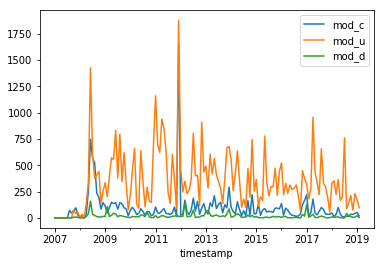

In [28]:
def modification():
    dfgb = deh.groupby(['timestamp','mod']).size().to_frame("count").reset_index()
    dfgb['mod_c'] = dfgb.apply(lambda row: row['count'] if row['mod'] == 'c' else 0, axis=1)
    dfgb['mod_d'] = dfgb.apply(lambda row: row['count'] if row['mod'] == 'd' else 0, axis=1)
    dfgb['mod_u'] = dfgb.apply(lambda row: row['count'] if row['mod'] == 'u' else 0, axis=1)
    dfgb = dfgb.groupby([pd.Grouper(key='timestamp',freq='MS')]).agg({'mod_c':'sum','mod_u':'sum','mod_d':'sum'})
    dfgb.plot()
modification()


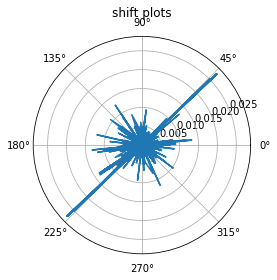

In [27]:
def shiftPlot():
    dfgb = deh.loc[deh['shifted'] == True]
    r = dfgb.apply(lambda r: np.sqrt(r['dlon']**2 + r['dlat']**2), axis=1)
    theta = dfgb.apply(lambda r: np.arctan2(r['dlat'],r['dlon']), axis=1)

    ax = plt.subplot(111, projection='polar')
    ax.plot(theta,r)
    ax.grid(True)
    ax.set_title("shift plots", va='bottom')
    plt.show()
shiftPlot()